In [3]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
%matplotlib widget
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy import stats
from scipy.stats import chi2 
from scipy.stats.distributions import  t
from scipy import signal
from scipy.signal import welch 
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.integrate import quad_vec
from scipy.special import gamma

In [ ]:
def waveData(advData, Rho, fs, rSamp, nperseg, ZpOffset = 0, ZvOffset = 0):
    advDS = advData.copy(deep=True)
    bursts = advDS.BurstCounter.values
    pTS = np.empty((len(bursts), int(nperseg/2)))
    Pressure_detrend = xr.zeros_like(advDS.Pressure)
    
    print('Converting pressure spectra')
    #Convert each burst of pressure spectra to vertical velocity using linear wave theory
    for i in enumerate(bursts):
        print('Evaluating burst '+str(i[0]+1)+' of '+str(len(bursts)))
        Pressure = advDS.Pressure.where(advDS.BurstNum.isin(i[1]), drop = True)
        Pressure_detrend[i[0]*len(Pressure):(i[0] + 1)*len(Pressure)] = signal.detrend(Pressure)
        Fp, Sw_prime = vt.sppConversion(Pressure, Rho, fs, nperseg, dBarToPascal = True, ZpOffset = ZpOffset, ZvOffset = ZvOffset, radianFrequency = False) 
        pTS[i[0]] = Sw_prime[1:]
    Tp = 1/Fp[1:] #First value is infinite, which is not compatible with matplotlib pcolormesh, so it's cut from the array
    
    #Convert detrended pressure to changes in meters of seawater
    H = (Pressure_detrend * 1000)/(Rho*9.81)
    Hmean = H.resample(time = rSamp).mean()
    Hstd = H.resample(time = rSamp).std()
    
    print('Creating dataset')
    #Create dataset
    waveData = xr.Dataset(
        data_vars=dict(
            waveSpectra=(["time", "period"], pTS.data),
            Hmean=(["time"], Hmean.data),
            Hstd=(["time"], Hstd.data),
        ),
        coords=dict(
            time=(["time"],advDS.time_start.data),
            period=(["period"], Tp.data),
        ),
        attrs=dict(description="Pressure spectra over both adv deployments"),
    )
    
    waveData.attrs['Rho'] = Rho.values
    waveData.attrs['Sample Frequency'] = fs
    waveData.attrs['Average Interval'] = rSamp
    waveData.attrs['Segment Length'] = nperseg
    waveData.attrs['Pressure Sensor Offset'] = ZpOffset
    waveData.attrs['Velocity Beam Offset'] = ZvOffset
    
    return waveData

In [20]:
# Function for estimating k from wave period and total depth using dispersion relationships
def wavedisp(wavper,h):
    """ 
    (omega,k,Cph,Cg) = wavedisp(wavper,h)
    ------------------
    Returns [omega,k,Cph,Cg]

    Inputs (can use arrays): 
            wavper - wave period [s]
            h - water depth [m]
   
    Outputs: 
    omega - angular wave frequency [radians/s]
    k - angular wave number	 [radians/m]
    Cph - phase speed [m/s]
    Cg - group velocity [m/s]
    """

    """ T Connolly 2014
    based on Matlab function wavedisp.m from S Lentz """
    # make sure inputs are arrays
    wavper=np.array(wavper)
    h=np.array(h)
    
    omega = (2*np.pi)/wavper
    g = 9.8
    c = omega**2*h/g
    
    x = np.sqrt(c)
    
    d = 100*np.ones(np.shape(wavper))
    tol = 5.*np.finfo(float).eps
    while (d>tol).any():
        f1=x*np.tanh(x)-c
        f2=x*(1/np.cosh(x))**2+np.tanh(x)
        x=x-f1/f2
        d=np.abs((c-x*np.tanh(x))/c)
    k=x/h
    Cph=omega/k
    Cg=(g*x*(1/np.cosh(x))**2+g*np.tanh(x))/(2*np.sqrt(g*k*np.tanh(x)))
    
    return (omega,k,Cph,Cg)

In [4]:
#Import data
advFilepath = 'ADV/adv1IntAvg.nc'
tempFilepath = 'Temperature/temp_final.nc'

ADVdata = xr.open_dataset(advFilepath)
TEMPdata = xr.open_dataset(tempFilepath)

In [188]:
ADVdata.time.where(ADVdata.BurstNum.isin(15), drop = True)

<xarray.DataArray 'time' (time: 38400)>
array(['2022-08-02T23:40:00.000000000', '2022-08-02T23:40:00.031250000',
       '2022-08-02T23:40:00.062500000', ...,
       '2022-08-02T23:59:59.906250000', '2022-08-02T23:59:59.937500000',
       '2022-08-02T23:59:59.968750000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-08-02T23:40:00 ... 2022-08-02T23:59:5...

83
0.509867531612524 0.7210615782201242 5.686720653825979


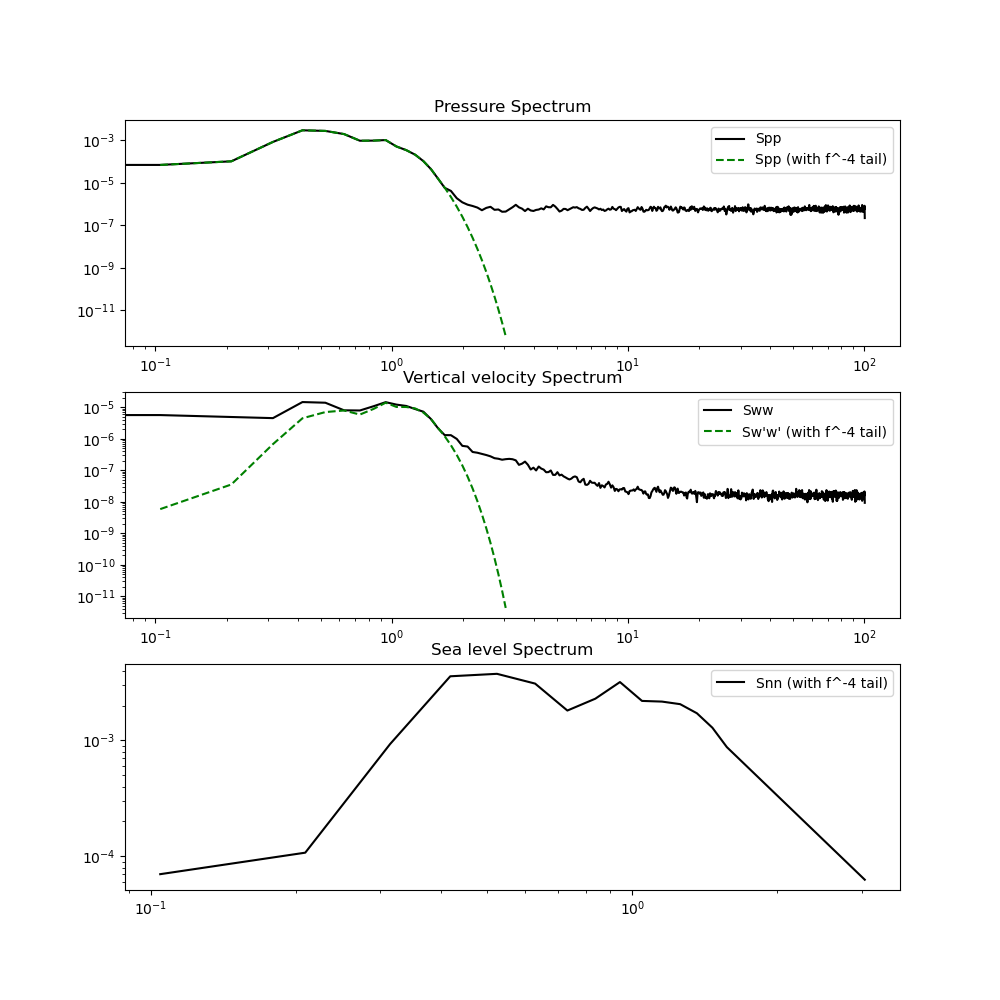

In [197]:
#Make a copy of the dataset to prevent accidental modification of original data
ADVds = ADVdata.copy(deep=True)
TEMPds = TEMPdata.copy(deep=True)

selBurstNumbers = [83]

#Instrument data
fs = ADVds.attrs['Sampling_Rate'] #The sampling rate of the instrument (32 Hz in this case)
ZpOffset = .58 #Height of ADV pressure sensor off the seafloor (m)
ZvOffset = .94 #Height of velocity measurement off the seafloor (m)
n = 38400 #Number of data points within the burst (must be consistent for all bursts)
window = 'hann' #The type of filter window used for the spectra calculation

#The length of the segment size used in the filter window
nperseg = 60 * fs #This corresponds to a 60 second window, which is 1920 data points

#The frequency at which the noise floor dominates the signal
#Estimated through observations made in the raw spectral data
fn = .34 #Frequency of noise floor cutoff in Hz

#Specify whether the function runs through the entire dataset or specific bursts
if selBurstNumbers:
    burstList = np.unique(selBurstNumbers)
else:
    burstList = np.unique(ADVdata.burst)
    
for i in burstList:
    print(i)
    burstW = ADVdata.Up.where(ADVdata.BurstNum.isin(i), drop = True) #Vertical velocity
    pressureRaw = ADVdata.Pressure.where(ADVdata.BurstNum.isin(i), drop = True) #Raw adv head pressure in dbar
    pressurePascal = pressureRaw * 10000 #Adv head pressure converted from dBar to Pascals

    #Use pressure to dictate the time frame of the density time series
    Rho = TEMPdata.Rho.sel(time = slice(pressureRaw.time[0],pressureRaw.time[-1])).mean()

    #Calculate PSD of both pressure time series, segment averaging the spectra via a specified segment length and filter window
    #All time series of pressure are linearly detrended to account for tidal effects
    FpRaw, SpRaw = welch(pressureRaw, fs = fs, nperseg = nperseg, window=window, detrend = 'linear')
    FpPa, SpPa = welch(pressurePascal, fs = fs, nperseg = nperseg, window=window, detrend = 'linear')
    Fw, Sw = welch(burstW, fs = fs, nperseg = nperseg, window=window, detrend = 'linear')

    #Convert spectra to radian frequency, but keep unconverted
    SpRawOmega = SpRaw / (2*np.pi)
    SpPaOmega = SpPa / (2*np.pi)
    SwOmega = Sw / (2*np.pi)

    #wavedisp function uses period (from frequency) and water depth (h) to calculate omega, k, and phase speed of waves
    #Convert frequency to radian frequency and wavenumber
    g = -9.8 # Gravity
    z = pressurePascal/(Rho*g) #Depth (m): the recorded pressure converted to meters of seawater
    H = np.mean(-z) + ZpOffset #Sea level height (m): mean pressure detected by the pressure sensor plus the height of sensor from the bottom
    Zp = np.mean(z) #Depth of pressure sensor (m)
    Zv = (-H) + ZvOffset #Depth of velocity sensor (m): Sea level height plus the height of the velocity transducers from the bottom
    T = 1/FpRaw #Period from previously calculate frequency

    #Calculate radian frequency and wavenumber
    omega,k,Cph,Cg = wavedisp(T, H)
    
    #Using linear wave theory to find gravity wave vertical velocity spectrum and wave height spectrum
    #Converting raw pressure spectrum to sea level spectrum (Jones and Monosmith, 2008)

    #Find the cutoff frequency of the spectrum
    a = 12 #Factor of 12 above the magnitude of pressure sensor noise floor
    b = 1.1 #Factor of 1.1 above peak wave frequency
    fnInd = np.where(FpRaw <=fn)[0][-1] #The array indices where the noise floor begins in the spectrum
    W = np.mean(SpRawOmega[fnInd:]) #Average magnitude of noise floor
    fp = omega[np.where(SpRawOmega == np.nanmax(SpRawOmega[:fnInd]))[0][0]] #The peak wave frequency
    fc = np.where((omega[:fnInd] > (fp * b)) & (SpRawOmega[:fnInd] > (W*a)))[0][-1] #The array indices of the final cutoff frequency

    #Converting the spectrum
    Kp = np.empty(len(k))
    p_prime = np.empty(len(omega))
    w_prime = np.empty(len(omega))
    for i in enumerate(k):
        Kpz = np.cosh(i[1]*(Zp+H))/np.cosh(i[1]*H)
        p_prime[i[0]] = (Rho*(-g))*(np.cosh(i[1]*(Zp+H))/np.cosh(i[1]*H))
        w_prime[i[0]] = (-omega[i[0]])*(np.sinh(i[1]*(Zv+H)))/(np.sinh(i[1]*H))
        Kp[i[0]] = Kpz**2 #(a*b)**2
    
    #Scale factor for converting pressure spectra (pascals) to vertical velocity spectra
    scaleFactor = w_prime**2 / p_prime**2

    Snu = (SpRawOmega/Kp) #Use conversion equation to estimate sea level spectrum
    Snu[fc+1:] = np.nan #Nan out everything that is considered the noise floor

    #Calculate the omega^-4 model tail of spectrum
    model_c = Snu[fc]/(omega[fc]**-4) #The constant to scale the model
    waveTail = (omega**-4) * model_c #Calculate the wave tail
    model_fc = np.where(omega == np.pi)[0][0] #Where the tail should end
    Snu[fc+1:model_fc] = waveTail[fc+1:model_fc]

    #Calculate wave height and period
    m0 = np.trapz((omega[1:model_fc]**0)*Snu[1:model_fc])
    m2 = np.trapz((omega[1:model_fc]**2)*Snu[1:model_fc])
    
    SpRaw_model = (Snu*Kp)
    SpPa_model = SpRaw_model*1e8
    
    #With modelled tail, convert the pascal pressure spectrum into vertical velocity spectrum
    Sw_prime = SpPa_model * scaleFactor

    Hrms = 2*np.sqrt(2*m0)
    Hs = 4 * np.sqrt(m0)
    T = (2*np.pi) * np.sqrt(m0/m2)

plt.figure(figsize = (10,10))
plt.subplot(311)
plt.title('Pressure Spectrum')
plt.loglog(omega, SpRawOmega, '-k', label = 'Spp')
plt.loglog(omega, SpRaw_model, '--g', label = 'Spp (with f^-4 tail)')
plt.legend()
plt.subplot(312)
plt.title('Vertical velocity Spectrum')
plt.loglog(omega, SwOmega, '-k', label = 'Sww')
plt.loglog(omega, Sw_prime, '--g', label = "Sw'w' (with f^-4 tail)")
plt.legend()
plt.subplot(313)
plt.title('Sea level Spectrum')
plt.loglog(omega, Snu, '-k', label = "Snn (with f^-4 tail)")
#plt.loglog(omega, Sw_prime, '--g', label = "Snn (with f^-4 tail)")
plt.legend()

print(Hrms, Hs, T)